In [43]:
import os
import torch
import numpy as np
import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SilhouetteShader, PhongShader, PointLights
)

In [18]:
# Set the cuda device 
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Load the obj and ignore the textures and materials.
verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/obj_000009.obj")
# verts, faces_idx, _ = load_obj("/home/hyosung/ImageDataset/PoseDataset/lm_full/models_obj/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

In [19]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. Refer to rasterize_meshes.py
# for an explanation of this parameter. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    bin_size=0
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=PhongShader(device=device, lights=lights)
)

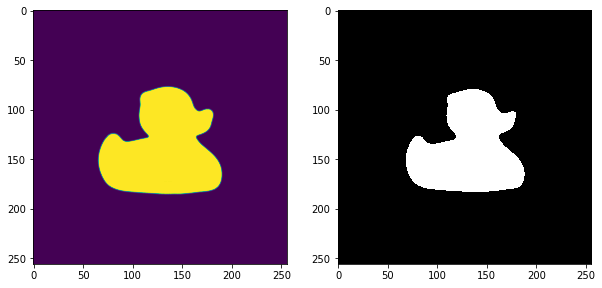

In [94]:
# Select the viewpoint using spherical angles  
distance = 200   # distance from camera to the object
elevation = 89.0   # angle of elevation in degrees
azimuth = 0.0  # angle of azimuth rotation in degrees

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

image_ref = (image_ref>0.0).astype(np.float32)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
# plt.grid("off")
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
# plt.grid("off")

In [130]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all the non zero values. 
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 0).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
#         self.camera_position = nn.Parameter(
#             torch.from_numpy(np.array([3.0,  6.9, -2.5], dtype=np.float32)).to(meshes.device))
#         self.R = nn.Parameter(torch.from_numpy(np.eye(3).reshape(1,3,3)).to(meshes.device))
        R_init = np.array([0.97163635, 0.23648003, 0., 0.02991929, -0.12293076, -0.99196416, -0.23457971, 0.96382844, -0.12651931])
        self.R = nn.Parameter(torch.from_numpy(R_init.reshape(1,3,3)).to(meshes.device))
        self.T = torch.from_numpy(np.array([[-0.0, 0.0, 400.0]])).to(meshes.device)

    def forward(self):
        
        # Render the image using the updated camera position. Based on the new position of the 
        # camer we calculate the rotation and translation matrices
#         R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
#         T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
#         U, S, V = torch.svd(self.R)
#         R_hat = torch.matmul(U, V.transpose(1,2)) # R_hat = U*V', det(R_hat)=1 since U and V are orthogonal matrices.
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=self.R, T=self.T)
#         image = (image>0.0).float()
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image
        
        # Calculate the silhouette loss

In [131]:
# We will save images periodically and compose them into a GIF.
filename_output = "./obj_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

Text(0.5, 1.0, 'Reference silhouette')

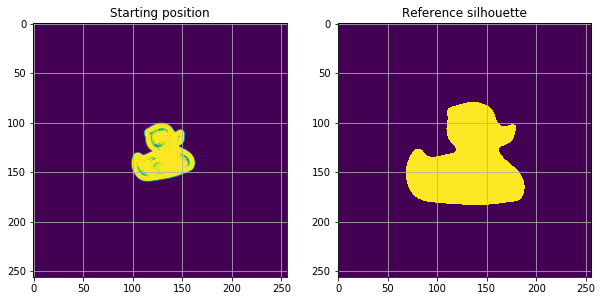

In [132]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid("off")
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid("off")
plt.title("Reference silhouette")

In [136]:
loss, _ = model()
print(loss.grad)
print(model.R)
R = model.R.detach().cpu().numpy()
print(np.linalg.det(R))

R is not a valid rotation matrix
R is not a valid rotation matrix
None
Parameter containing:
tensor([[[ 1.8711, -0.0130,  0.0738],
         [ 0.1284,  0.1514, -2.2944],
         [ 0.0360,  1.9178,  0.2050]]], device='cuda:0', dtype=torch.float64,
       requires_grad=True)
[8.31028482]


R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

/home/hyosung/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a valid rotation matrix
R is not a

KeyboardInterrupt: 

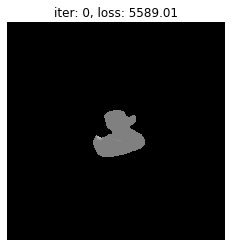

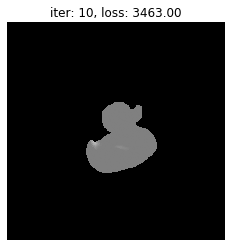

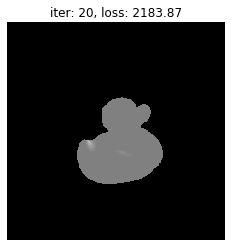

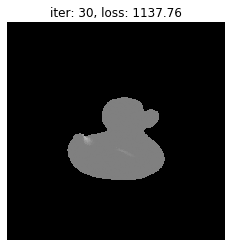

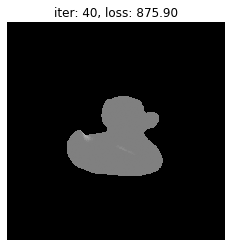

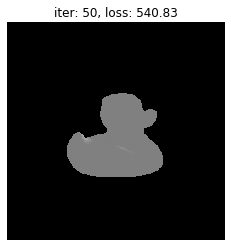

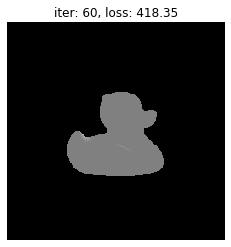

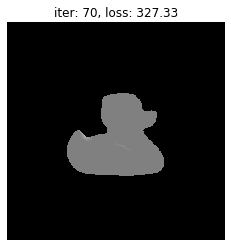

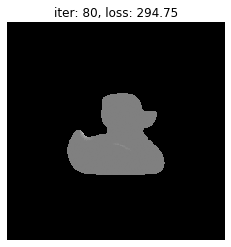

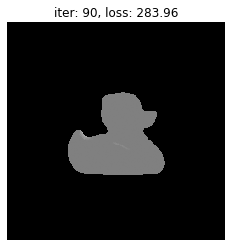

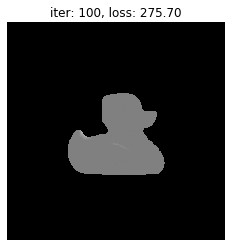

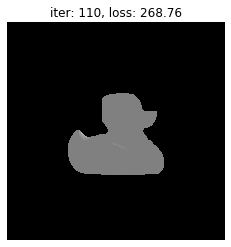

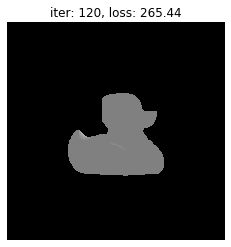

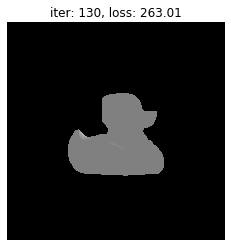

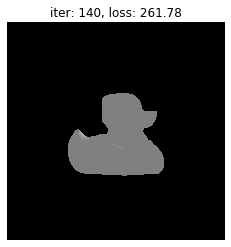

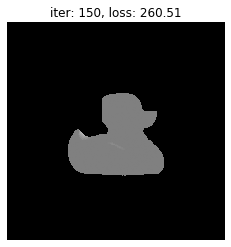

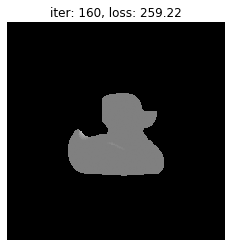

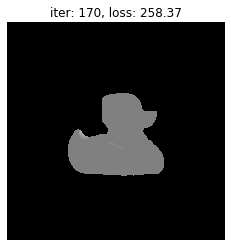

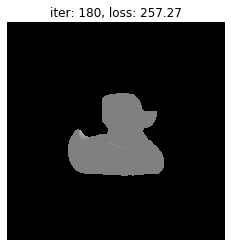

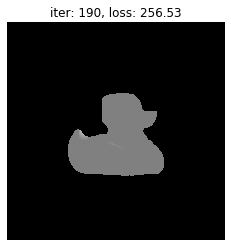

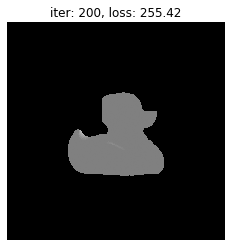

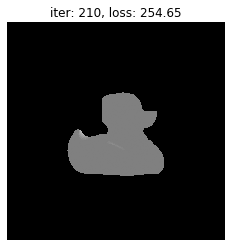

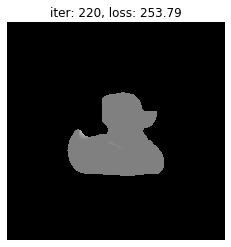

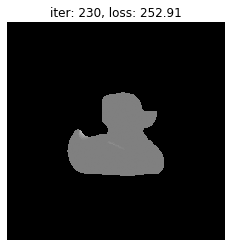

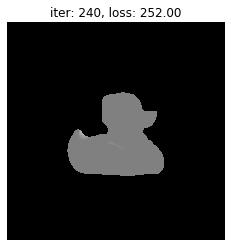

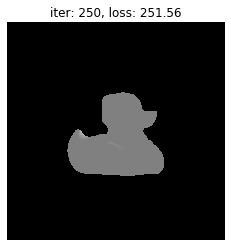

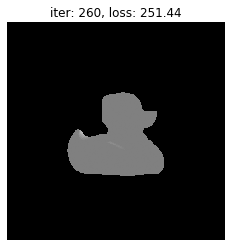

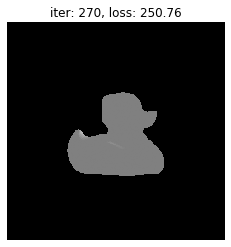

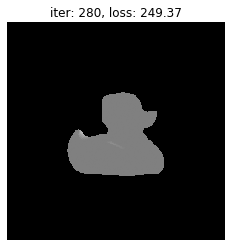

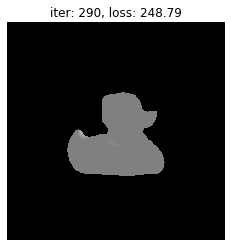

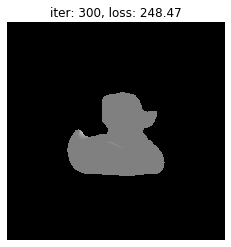

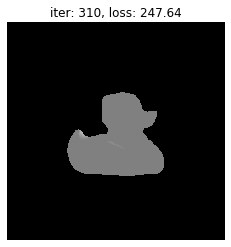

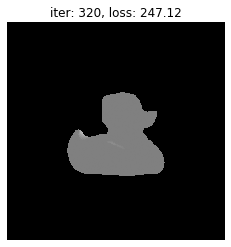

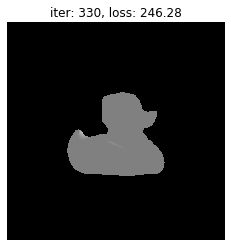

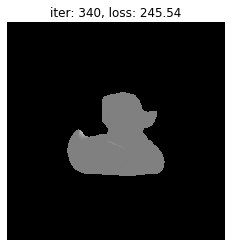

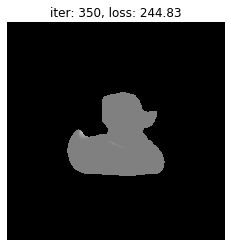

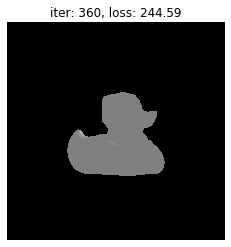

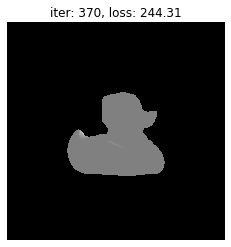

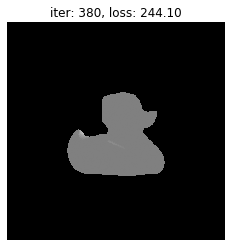

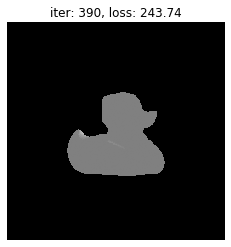

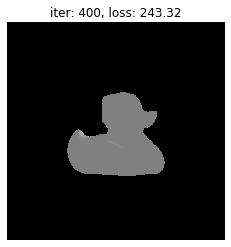

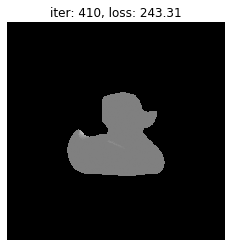

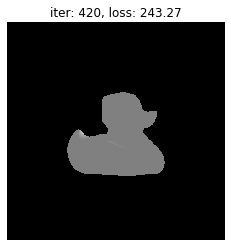

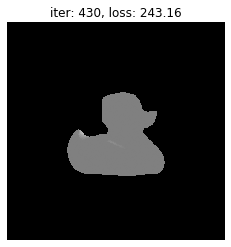

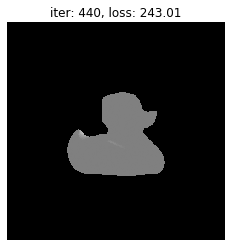

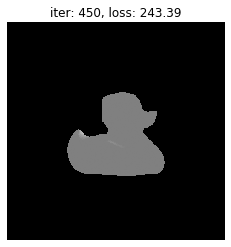

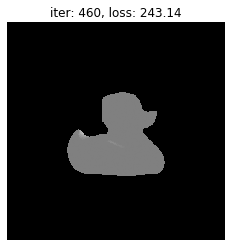

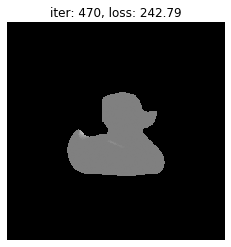

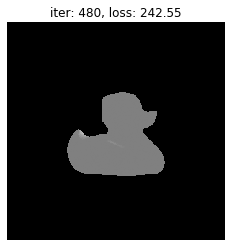

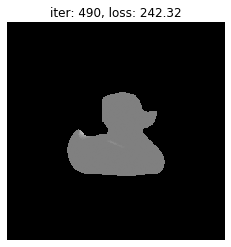

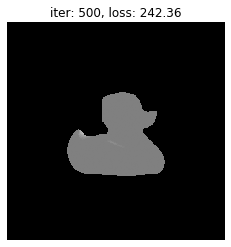

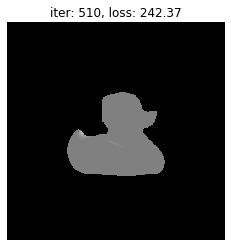

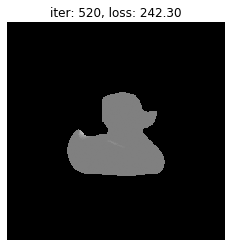

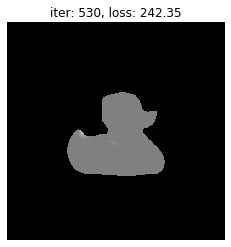

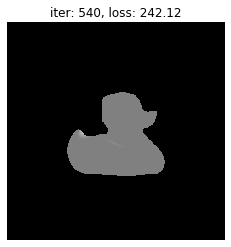

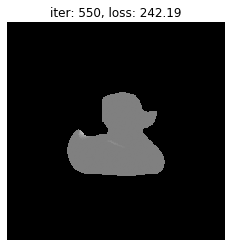

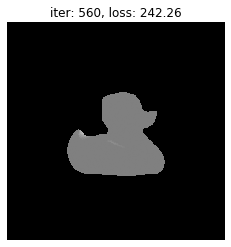

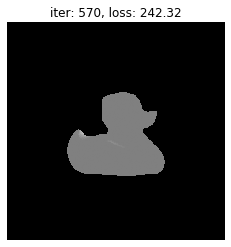

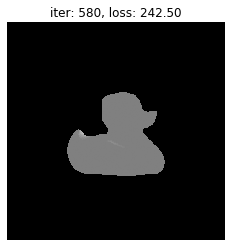

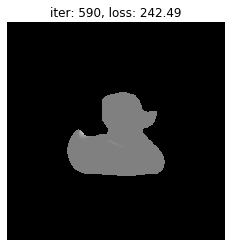

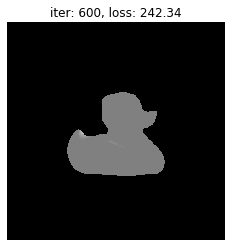

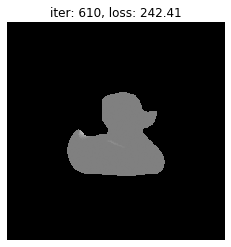

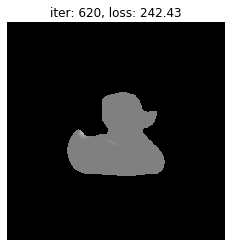

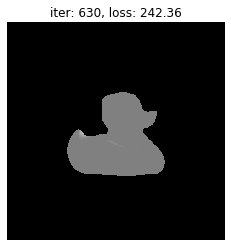

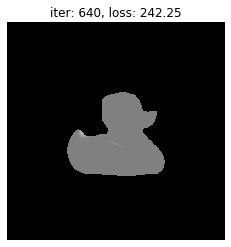

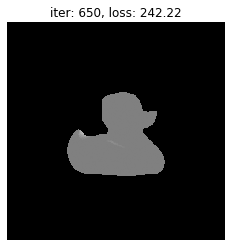

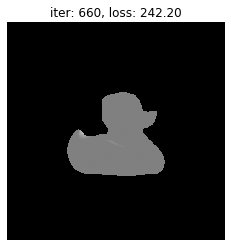

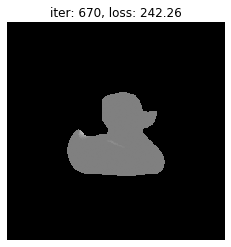

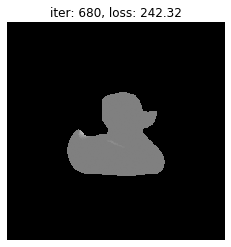

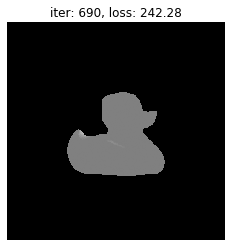

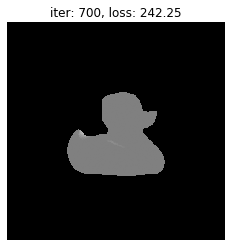

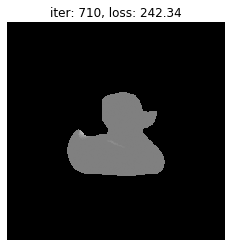

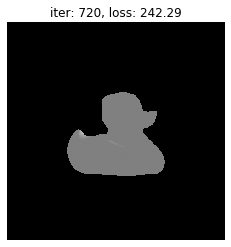

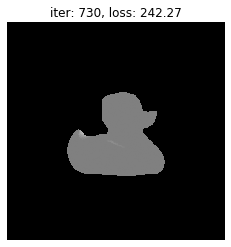

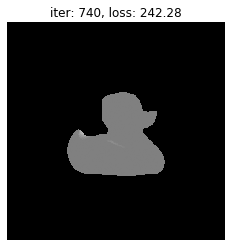

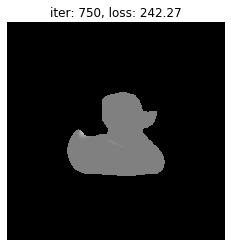

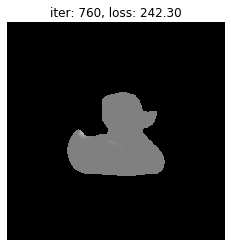

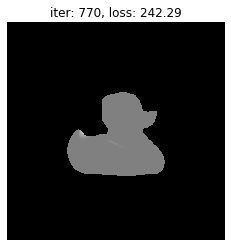

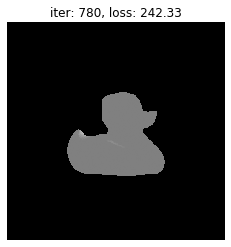

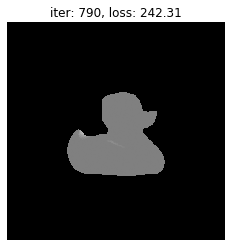

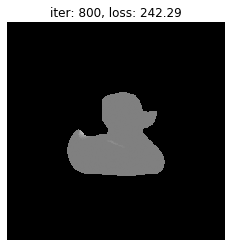

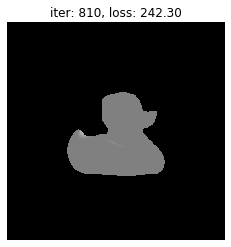

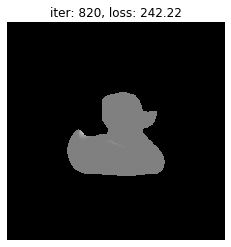

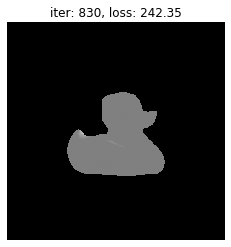

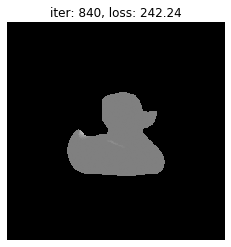

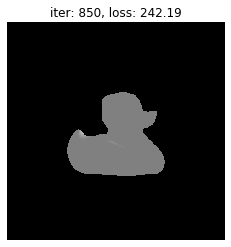

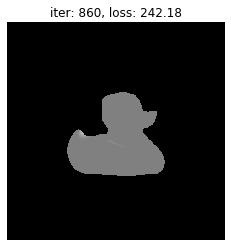

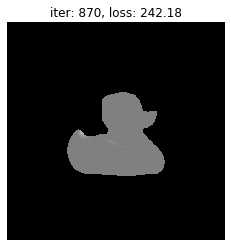

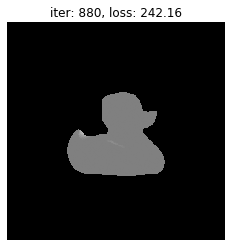

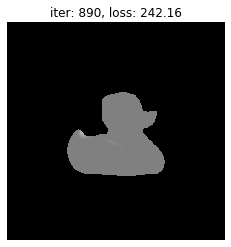

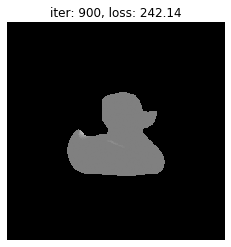

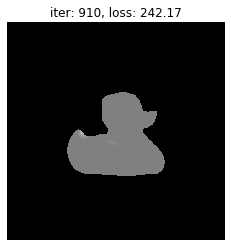

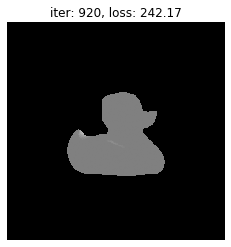

In [134]:
loop = tqdm.notebook.tqdm(range(1000))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
#         R = look_at_rotation(model.camera_position[None, :], device=model.device)
#         T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        R = model.R
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=model.T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
    
writer.close()

In [9]:
print(R.detach().cpu().numpy())
R = R.detach().cpu().numpy()
print(T.detach().cpu().numpy())
print(np.linalg.det(R))

[[[nan nan nan]
  [nan nan nan]
  [nan nan nan]]]
[[-0.0000000e+00 -1.4898262e-08  2.9999998e+00]]
[nan]


/home/hyosung/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
